In [1]:
from KMeans import *
from openml.datasets import list_datasets, get_datasets
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

## Flags

In [2]:
# flag for researching datasets
search = False
# flag for re-measuring time executions
measure = False

## Dataset retrieval

In [3]:
if search:
    query = "NumberOfInstances > 100000 &\
             NumberOfInstances < 1000000 &\
             NumberOfNumericFeatures > 3 &\
             NumberOfNumericFeatures < 25 &\
             NumberOfMissingValues == 0 &\
             NumberOfSymbolicFeatures == 0"

    dataset_dataframe = list_datasets(output_format="dataframe").query(query)
    dataset_dataframe = dataset_dataframe.drop_duplicates(['name']).drop_duplicates(['NumberOfNumericFeatures']).sort_values(by=['NumberOfNumericFeatures'])
    dataset_ids = dataset_dataframe['did'][:10]
    dataset_ids.to_csv('./data/dataset_ids.csv', index=False)
dataset_ids = pd.read_csv('./data/dataset_ids.csv')['did']
dataset_list = get_datasets(dataset_ids=dataset_ids)
X_list = [dataset.get_data()[0].select_dtypes([np.number]).to_numpy() for dataset in dataset_list]

## Plot definitions

In [4]:
pad = 20
figsize = (10,8)

In [5]:
def boxplot(df, columns, title, xlabel, ylabel, tick_freq=None):
    plt.figure(figsize=figsize)
    df_melted = pd.melt(df, value_vars=columns)
    ax = sns.boxplot(x="variable", y="value", data=df_melted)
    ax.set_title(title, pad=pad)
    if tick_freq is not None:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_freq))
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.show()

In [6]:
def scatterplot(df, x, y, title, xlabel, ylabel):
    plt.figure(figsize=figsize)
    ax = sns.scatterplot(data=df, x=x, y=y)
    ax.set_title(title, pad=pad)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.show()

In [7]:
def getPlots(df, speculation=False):
    sns.set_context("paper", font_scale=1.5)

    df['ratio_AB_avg'] = df['t_A_avg']/df['t_B_avg']
    
    # Box-plot of avgs
    if speculation:
        boxplot(df, columns = ['t_A_avg', 't_B_avg', 't_correction_avg', 't_speculation_avg'], title = 'Average execution time of A, B, correction and speculation', xlabel = 'Task', ylabel = 'Execution time in ms', tick_freq=0.05)
        
    else:
        boxplot(df, columns = ['t_A_avg', 't_B_avg'],  title = 'Average execution time of A, B', xlabel = 'Task', ylabel = 'Execution time in ms', tick_freq=0.05)
        
    # Box-plot of ratios
    if speculation:
        df_measurements_speculation['ratio_A_correction_avg'] = df_measurements_speculation['t_A_avg']/df_measurements_speculation['t_correction_avg']
        df_measurements_speculation['ratio_B_correction_avg'] = df_measurements_speculation['t_B_avg']/df_measurements_speculation['t_correction_avg']
        df_measurements_speculation['ratio_B_speculation_avg'] = df_measurements_speculation['t_B_avg']/df_measurements_speculation['t_speculation_avg']
        boxplot(df, columns = ['ratio_AB_avg'], title = r'Ratio $\frac{avg(t_A)}{avg(t_B)}$', xlabel = 'Task', ylabel = 'Ratio value', tick_freq=20)
        boxplot(df, columns = ['ratio_A_correction_avg'], title = r'Ratio $\frac{avg(t_A)}{avg(t_{correction})}$', xlabel = 'Task', ylabel = 'Ratio value', tick_freq=20)
        boxplot(df, columns = ['ratio_B_correction_avg', 'ratio_B_speculation_avg'], title = r'Ratio $\frac{avg(t_B)}{avg(t_{correction})}$ and Ratio $\frac{avg(t_B)}{avg(t_{speculation})}$', xlabel = 'Task', ylabel = 'Ratio value', tick_freq=5)

    else:
        boxplot(df, columns = ['ratio_AB_avg'], title = r'Ratio $\frac{avg(t_A)}{avg(t_B)}$', xlabel = 'Task', ylabel = 'Ratio value', tick_freq=5)
        
    # Scatter plots - n_clusters
    scatterplot(df, x='n_clusters', y='ratio_AB_avg', title=r'Relation between n_clusters and $\frac{avg(t_A)}{avg(t_B)}$', xlabel='Number of clusters', ylabel=r'$\frac{avg(t_A)}{avg(t_B)}$')
    scatterplot(df.groupby(['n_clusters']).mean(), x='n_clusters', y='ratio_AB_avg', title=r'Relation between n_clusters and $\frac{avg(t_A)}{avg(t_B)} - aggregation over all datasets $', xlabel='Number of clusters', ylabel=r'$\frac{avg(t_A)}{avg(t_B)}$')
    scatterplot(df[df.n_datapoints == df.iloc[0].n_datapoints], x='n_clusters', y='ratio_AB_avg', title=r'Relation between n_clusters and $\frac{avg(t_A)}{avg(t_B)} - fixed dataset $', xlabel='Number of clusters', ylabel=r'$\frac{avg(t_A)}{avg(t_B)}$')
    
    # Scatter plots - cluster sizes
    df['ratio_max_min_cluster_size'] = df['max_cluster_size']/df['min_cluster_size']
    scatterplot(df, x='avg_cluster_size', y='ratio_AB_avg', title=r'Relation between avg(cluster_size) and $\frac{avg(t_A)}{avg(t_B)}$', xlabel='Average cluster size', ylabel=r'$\frac{avg(t_A)}{avg(t_B)}$')
    scatterplot(df, x='ratio_max_min_cluster_size', y='ratio_AB_avg', title=r'Relation between skew in cluster size (i.e:  $\frac{max(cluster-size)}{min(cluster-size)}$) and  $\frac{avg(t_A)}{avg(t_B)}$', xlabel=r'Skew: $\frac{max(cluster-size)}{min(cluster-size)}$', ylabel=r'$\frac{avg(t_A)}{avg(t_B)}$')
    scatterplot(df, x='ratio_max_min_cluster_size', y='t_A_avg', title=r'Relation between skew in cluster size (i.e:  $\frac{max(cluster-size)}{min(cluster-size)}$) and avg(t_A)', xlabel=r'Skew: $\frac{max(cluster-size)}{min(cluster-size)}$', ylabel='avg(t_A)')
    scatterplot(df, x='ratio_max_min_cluster_size', y='t_B_avg', title=r'Relation between skew in cluster size (i.e: $\frac{max(cluster-size)}{min(cluster-size)}$)', xlabel=r'Skew: $\frac{max(cluster-size)}{min(cluster-size)}$', ylabel='avg(t_B)')

## Measurements basic k-means

In [8]:
if measure:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        i = 0
        df_measurements = pd.DataFrame(columns=['n_datapoints', 'n_features', 'n_clusters', 't_A_avg', 't_A_min', 't_A_max', 't_B_avg', 't_B_min', 't_B_max', 'avg_cluster_size', 'min_cluster_size', 'max_cluster_size'])
        for k, X in enumerate(X_list):
            print(f"Processing {k}° dataset...")
            for K in range(3, 15):
                # Fit kmeans
                labels, centroids, A_time, B_time = KMeans(X, K, num_iter=100, measure=True)
                # Get cluster size
                clusters_size = np.array([X[labels == k].shape[0] for k in range(K)])
                # Append to df
                df_measurements.loc[i] = [X.shape[0], X.shape[1], K, np.mean(A_time), np.min(A_time), np.max(A_time), np.mean(B_time), np.min(B_time), np.max(B_time), np.nanmean(clusters_size), np.nanmin(clusters_size), np.nanmax(clusters_size)]
                i += 1
        df_measurements.to_csv('./data/measurements.csv', index=False)

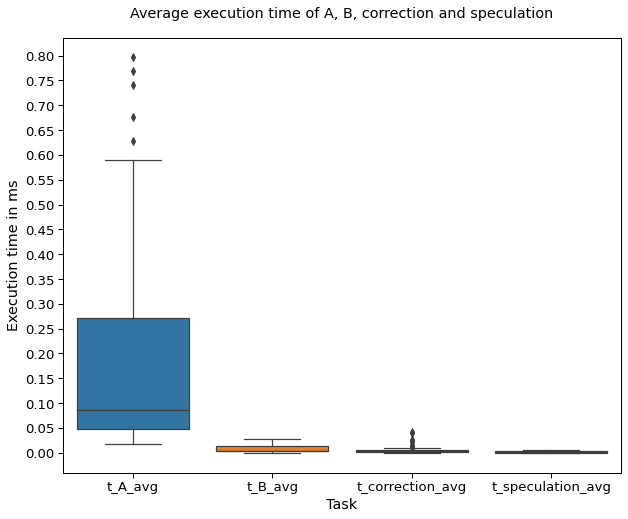

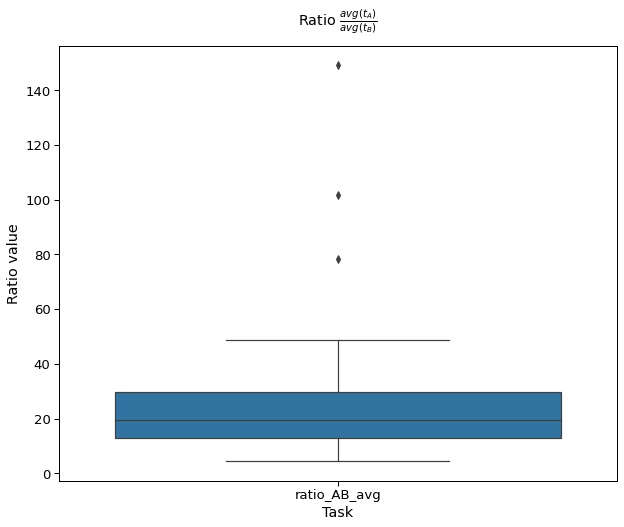

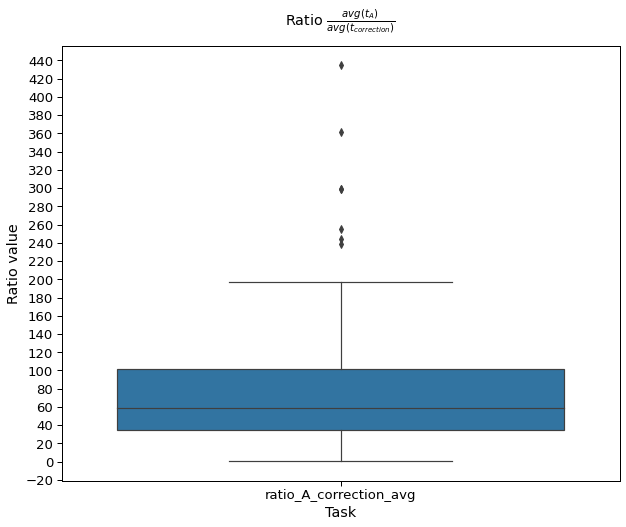

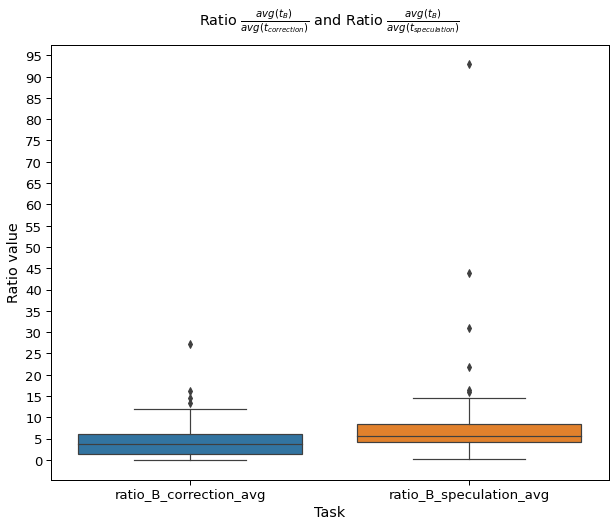

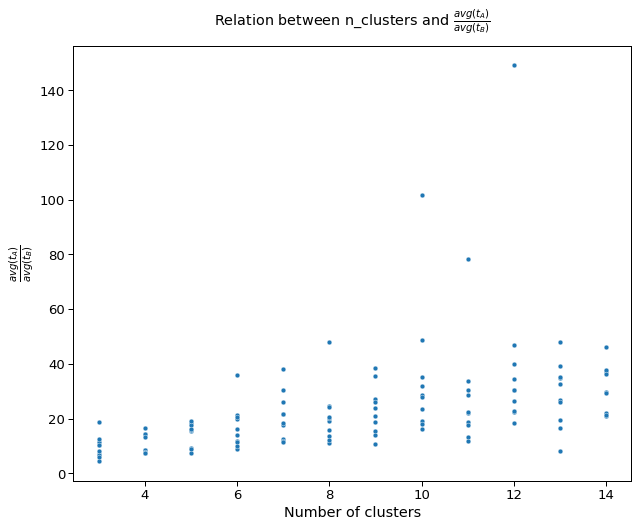

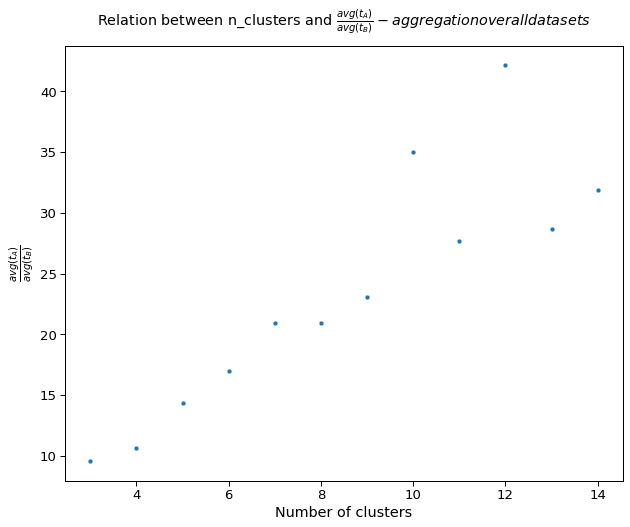

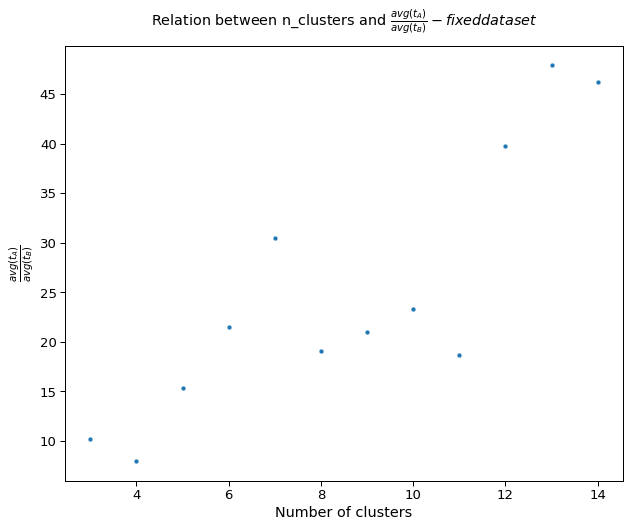

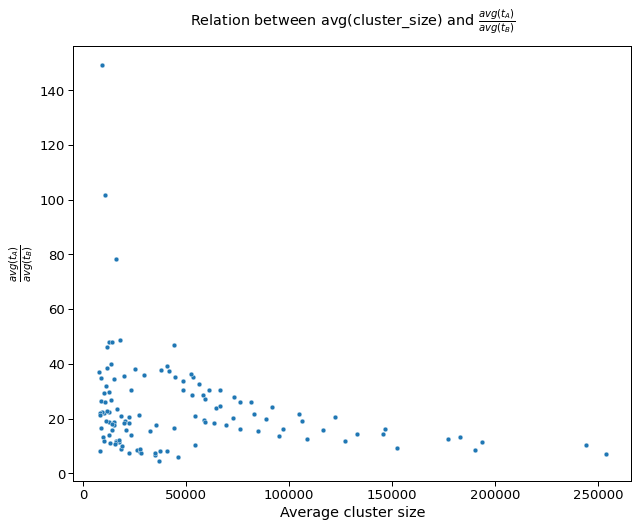

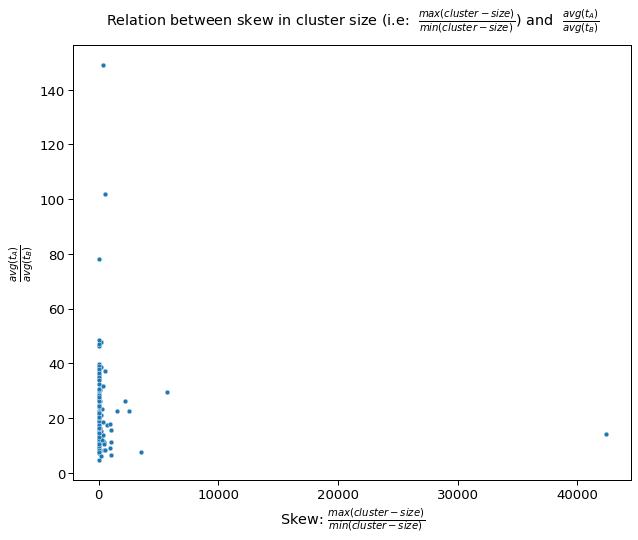

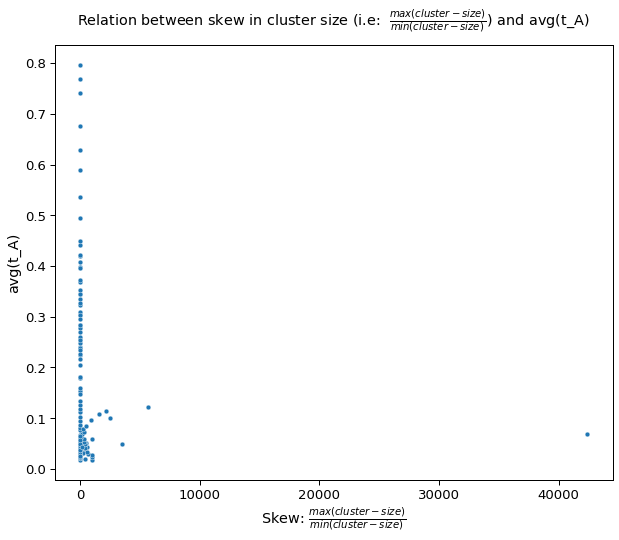

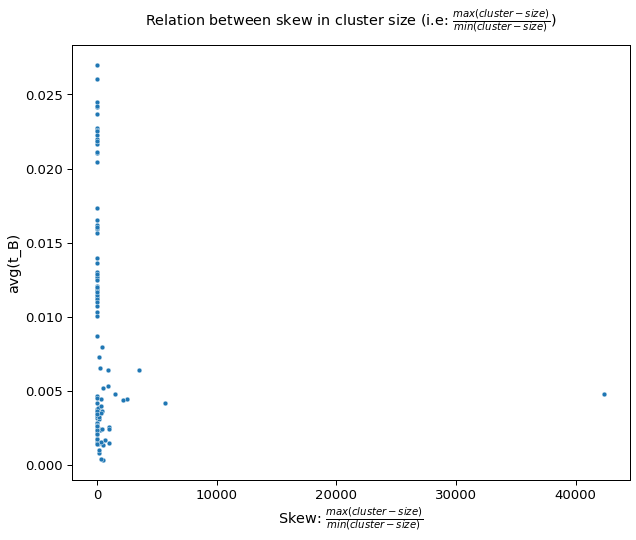

In [11]:
df_measurements = pd.read_csv('./data/measurements.csv')
getPlots(df_measurements_speculation, speculation = True)

## Measurements speculated k-means

In [9]:
if measure:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        i = 0
        subsample_size=0.01
        df_measurements_speculation = pd.DataFrame(columns=['n_datapoints', 'n_features', 'n_clusters', 't_A_avg', 't_A_min', 't_A_max', 't_B_avg', 't_B_min', 't_B_max', 'avg_cluster_size', 'min_cluster_size', 'max_cluster_size',\
                                                't_speculation_avg', 't_speculation_min', 't_speculation_max', 't_correction_avg', 't_correction_min', 't_correction_max', 'subsample_size'])
        for k, X in enumerate(X_list):
            print(f"\nProcessing {k}° dataset...")
            for K in range(3, 15):
                # Fit kmeans
                print(f"{K} -- ", end='')
                labels, centroids, A_time, B_time, speculation_time, correction_time  = KMeans_speculation(X, K, num_iter=100, measure=True, subsample_size = subsample_size)
                # Get cluster size
                clusters_size = np.array([X[labels == k].shape[0] for k in range(K)])
                # Append to df
                df_measurements_speculation.loc[i] = [X.shape[0], X.shape[1], K, np.mean(A_time), np.min(A_time), np.max(A_time), np.mean(B_time),\
                                          np.min(B_time), np.max(B_time), np.nanmean(clusters_size), np.nanmin(clusters_size), np.nanmax(clusters_size),\
                                          np.mean(speculation_time), np.min(speculation_time), np.max(speculation_time), np.mean(correction_time), np.min(correction_time), np.max(correction_time), subsample_size]
                i += 1
        df_measurements_speculation.to_csv('./data/measurements_speculation.csv', index=False)

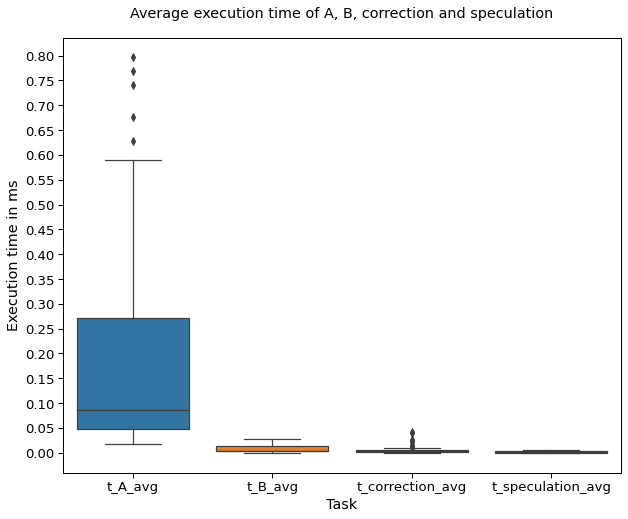

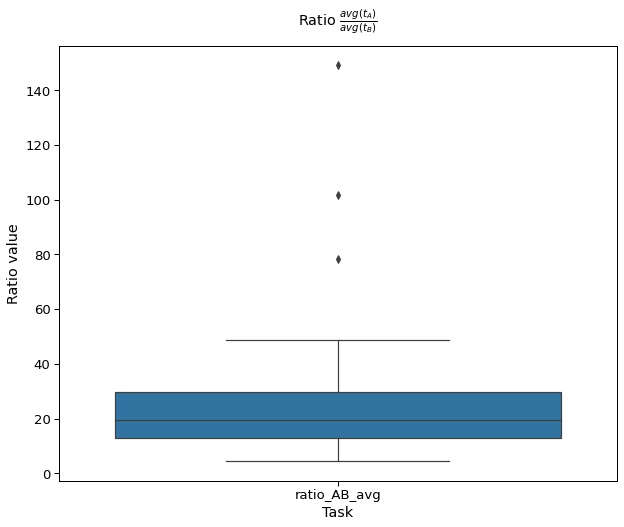

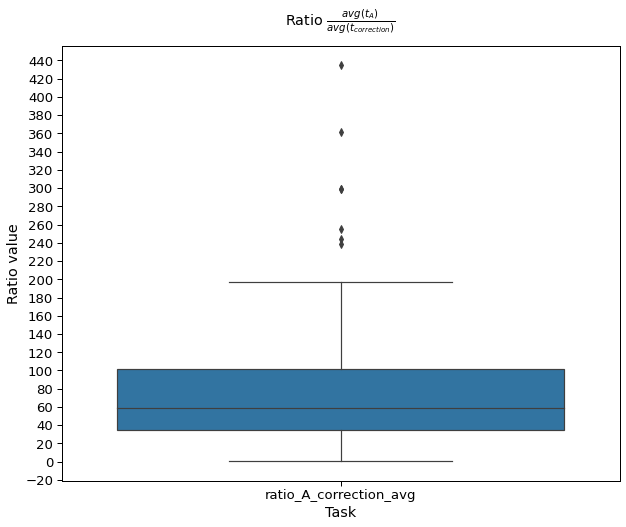

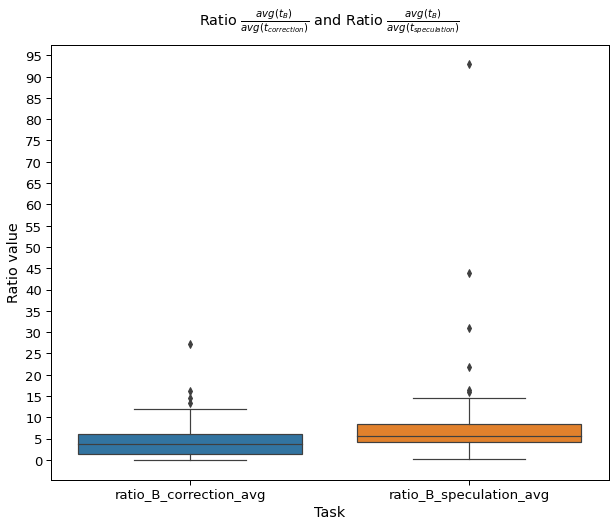

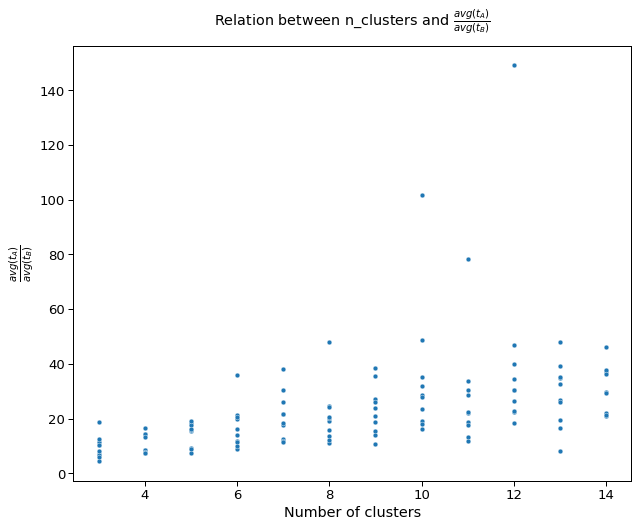

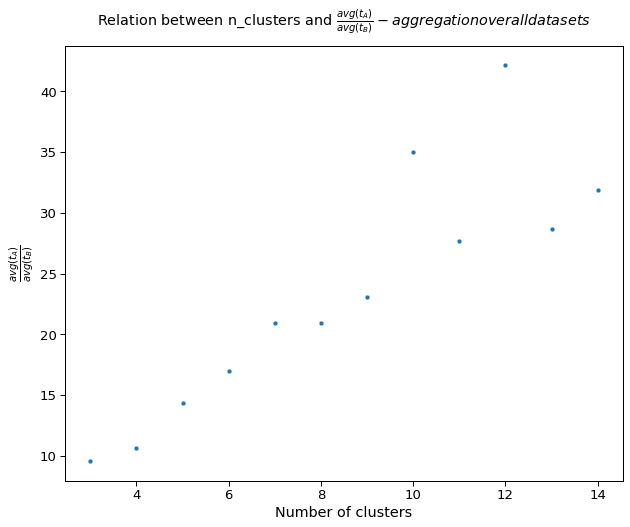

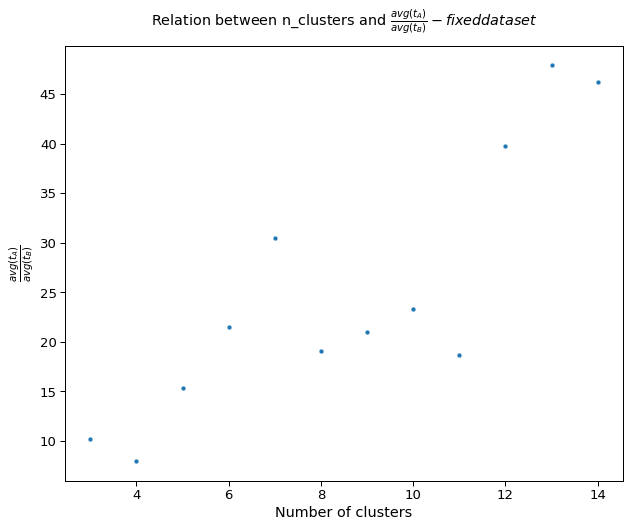

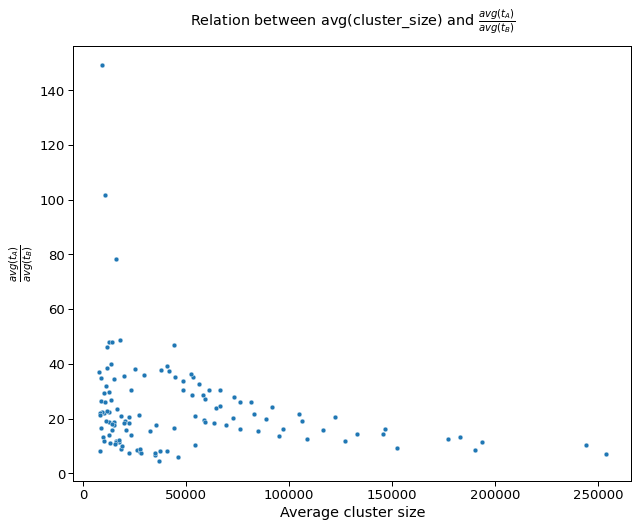

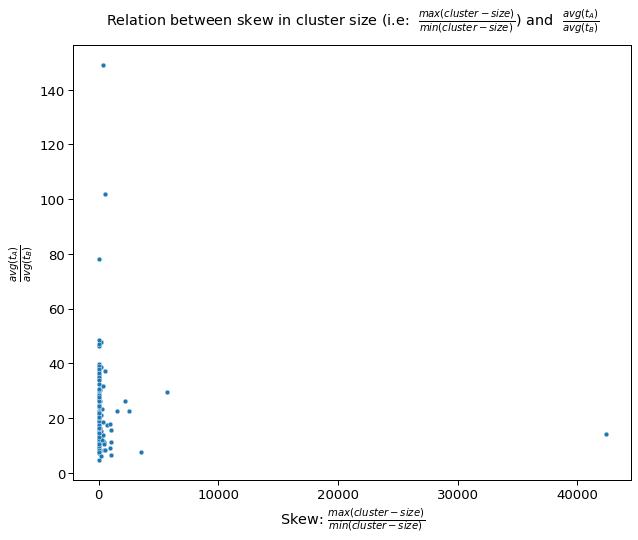

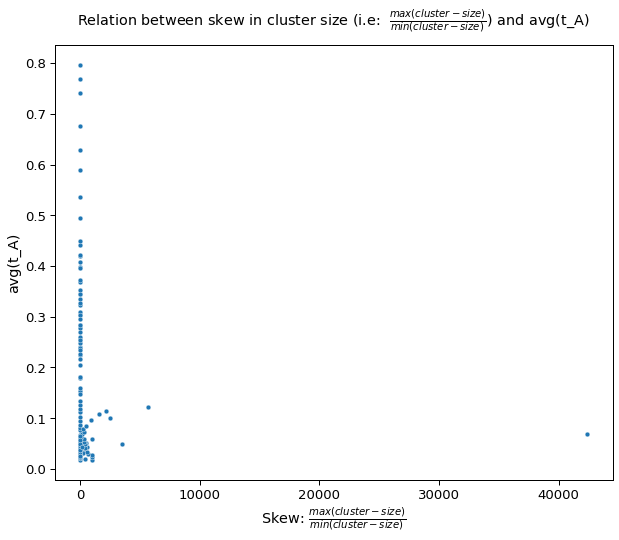

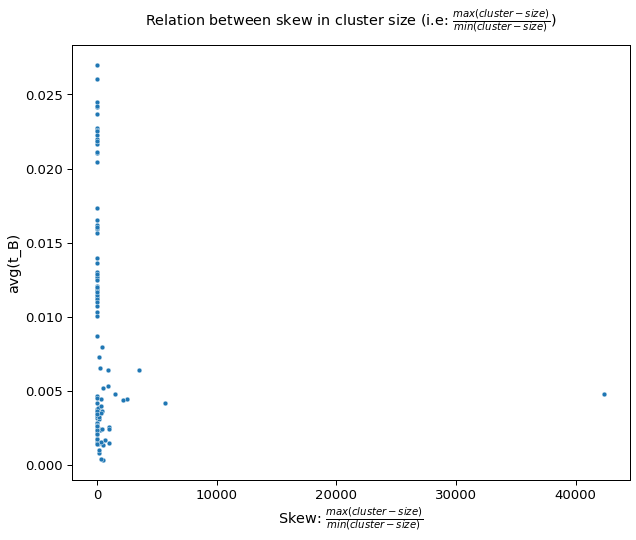

In [10]:
df_measurements_speculation = pd.read_csv('./data/measurements_speculation.csv')
getPlots(df_measurements_speculation, speculation = True)